In [23]:
from tqdm import tqdm
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import json
from PIL import Image
import cv2 as cv
from datetime import datetime
from torchvision import models, datasets
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
import os
from torch.utils.data import DataLoader, random_split
import torchmetrics
from torch.utils.data import Dataset
import os
from pathlib import Path
import segmentation_models_pytorch as smp
# from ultralytics import YOLO

In [3]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(device)

cuda:0


## DATA PREP

Для каждой картинки нужно собрать стэк масок с каждым инстансом<br>


In [7]:
json_file=r"HuBMAP dataset\polygons.jsonl"
img_path=r"HuBMAP dataset\imgs"

In [8]:
class HubmapDataSet(Dataset):
    
    def __init__(self, json_file, img_path, transform=None, return_stack=False):
        with open(json_file) as file:
            self.polygons = pd.read_json(json_file, lines=True)
        self.img_path = img_path
        self.transform = transform
        self.return_stack = return_stack
    
    def __len__(self):
        return len(self.polygons)
    
    def __getitem__(self, index):
        if torch.is_tensor(index):
            index = index.tolist()
            
        norm = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])    
            
        img_name = os.path.join(self.img_path,
                               self.polygons.iloc[index, 0])

        image = Image.open(img_name+'.tif')
        
        n_targets = len(self.polygons.annotations[index])
        
        self.mask_stack = np.zeros((n_targets, 512, 512), dtype=np.uint8)
        
        for n, coord_dict in enumerate(self.polygons.annotations[index]):
            if coord_dict['type'] == 'blood_vessel':
                polygons = np.array(coord_dict['coordinates'][0])
                cv.fillPoly(self.mask_stack[n], pts=[polygons], color=1)
        
            if coord_dict['type'] == 'glomerulus':
                polygons = np.array(coord_dict['coordinates'][0])
                cv.fillPoly(self.mask_stack[n], pts=[polygons], color=2)
        
            if coord_dict['type'] == 'unsure':
                polygons = np.array(coord_dict['coordinates'][0])
                cv.fillPoly(self.mask_stack[n], pts=[polygons], color=3)

                
        mask = self.mask_stack[0]
        for i in range(1, n_targets):
            mask = cv.bitwise_xor(mask, self.mask_stack[i])
        mask[np.isnan(mask)] = 0        
                
        norm = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                   
        image = np.array(image)/255        
        
        image = image.transpose((2,0,1)).astype(np.float32)
        image = norm(torch.tensor(image))
        mask = mask.astype(np.float32)
        
        sample = (image, mask)
        
        if True:
            return (image, mask, self.mask_stack)
        
        return sample

In [9]:
dataset = HubmapDataSet(json_file, img_path, return_stack=True)

In [3]:
# class SegDataset(Dataset):
    
#     def __init__(self, json_file, img_path, transform=None):
#         with open(json_file) as file:
#             self.polygons = pd.read_json(json_file, lines=True)
#         self.img_path = img_path
#         self.transform = transform        
    
#     def __len__(self):
#         return len(self.polygons)
# #         return len(annotations)
    
#     def __getitem__(self, index):
#         if torch.is_tensor(index):
#             index = index.tolist()
            
#         img_name = os.path.join(self.img_path,
#                                self.polygons.iloc[index, 0])

#         image = Image.open(img_name+'.tif')
        
#         mask = np.zeros((1,image.height,image.width), dtype=np.float32)
        
#         for data_dict in self.polygons.annotations[index]:
#             if data_dict['type'] == 'blood_vessel':
#                 pts = np.array(data_dict['coordinates'][0])
#                 cv.fillPoly(mask[0], pts=[pts], color=1)
# #             if data_dict['type'] == 'glomerulus':
# #                 pts = np.array(data_dict['coordinates'][0])
# #                 cv.fillPoly(mask, pts=[pts], color=2)
                
#         norm = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                   
#         image = np.array(image)/255        
        
#         image = image.transpose((2,0,1)).astype(np.float32)
#         image = norm(torch.tensor(image))
#         sample = (image, mask.astype(np.float32))
            
#         return sample

In [10]:
def show_masked(img, mask):
#     img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
#     print(img.shape, mask.shape)
    mask_full = np.zeros_like(img, dtype=np.uint8)
    mask_full[:,:,0] = mask
    masked_img = cv.bitwise_or(img, mask_full)
    plt.imshow(masked_img)
    

def img_denorm(x):
    x = x + np.abs(x.min())
    x = x/x.max()
    x = x * 255
    x = x.astype(np.uint8)
    
    return x

In [12]:
train_data = torch.load('data\TRAIN_DATA_split_2.pt')
test_data = torch.load('data\TEST_DATA_split_2.pt')

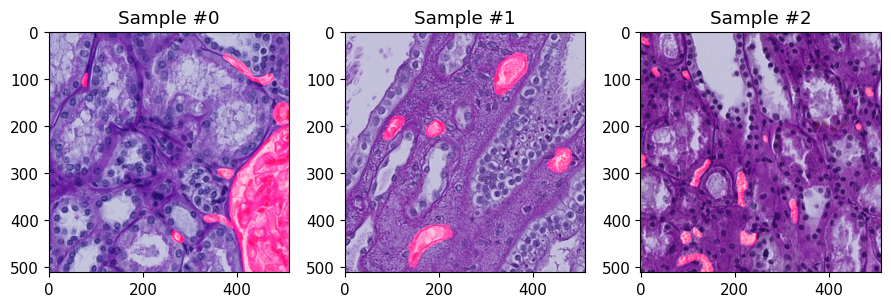

In [8]:
%matplotlib inline

# IMG + mask examples

fig = plt.figure(figsize=(12,12))

i=0
while i < 3:
    n = np.random.randint(0, len(test_data))

    img, mask, _ = test_data[n]

    ax = plt.subplot(1, 4, i+1)
    plt.tight_layout()
    ax.set_title(f'Sample #{i}')
    
    show_masked((img_denorm(img.detach().numpy().transpose(1,2,0))), (mask.squeeze()*255).astype('uint8'))
    
    i+=1

In [36]:
batch_size = 15

test_loader = DataLoader(test_data,
                         batch_size=batch_size,
                         shuffle=True)

## wsi rec data

In [13]:
json_file=r"HuBMAP dataset\polygons.jsonl"
img_path=r"HuBMAP dataset\imgs"
tile_meta_path = r"HuBMAP dataset\tile_meta.csv"

In [14]:
# Берем изображение по index, строим по нему изображение 9х9,с ним в центре,
# на этом изображении делаем random crop и учимся (+ с маской делаем тоже самое)

class TileNineByNine(Dataset):
    
    def __init__(self, json_file, images_path, tile_meta_path):
        with open(tile_meta_path) as f:
            self.tile_meta = pd.read_csv(f)

        with open(json_file) as f:
            self.polygons = pd.read_json(f, lines=True)
            
        self.images_path = images_path
        
    def __len__(self):
        return len(self.polygons)
    
    def transformation(self, image, mask):
        
        need_crop = (image.shape[0] > 512)
        
        image = Image.fromarray(image)
        mask_img = Image.fromarray(mask)
        
        rotate_params = np.random.choice([0.0, 90.0, 180.0, 270.0, 0.0])
        
        if need_crop:
            crop_size = np.random.choice(range(412, 812)) #1530
            crop_params = transforms.RandomCrop.get_params(image, [crop_size, crop_size])            
            image = TF.resized_crop(image,*crop_params,(512,512))
            mask_img = TF.resized_crop(mask_img,*crop_params,(512,512))
        
        flip = np.random.random()

        flip_v = np.random.random()
        pad = np.random.random()
        jitter = np.random.random()
        
        
            
        if jitter > 0.3:
            image = transforms.ColorJitter(brightness=.5, hue=.3)(image)
            
        image = TF.rotate(image,rotate_params)
            
        if flip > 0.7:
            image = TF.hflip(image)
            
        if flip_v > 0.7:
            image = TF.vflip(image)       
        
        mask_img = TF.rotate(mask_img,rotate_params)
                
        if flip > 0.7:
            mask_img = TF.hflip(mask_img)
                
        if flip_v > 0.7:
            mask_img = TF.vflip(mask_img)
                       
                
        mask = (np.array(mask_img))           
            
        return (image, mask)
    
    def __getitem__(self, index):
        if torch.is_tensor(index):
            index = index.tolist()
            
        norm = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        
        img_name = self.polygons.iloc[index, 0]                              
        
        image = Image.open(os.path.join(self.images_path, img_name)+'.tif')
        
        image_large = np.zeros((512*3, 512*3, 3), dtype=np.uint8)
        mask_large = np.zeros((512*3, 512*3), dtype=np.uint8)
        
        # Для image нужно получить #wsi и координаты i,j
        n_wsi = self.tile_meta.source_wsi[self.tile_meta.id == img_name].item()

        self.df_wsi = self.tile_meta[self.tile_meta.source_wsi == n_wsi]
        
        col_coord, row_coord = self.df_wsi.i[self.tile_meta.id == img_name].item(), \
        self.tile_meta.j[self.tile_meta.id == img_name].item()
        
        
        # Левый верхн угол
        init_row = row_coord - 512
        
        # Заполняем большое изображение
        is_blank_flag = False
        y = 0
        for i in range(3):
            x=0
            init_col = col_coord - 512

            for j in range(3):
                
                image_small_name = self.df_wsi.id[np.logical_and((self.df_wsi.i == init_col),
                                                                    (self.df_wsi.j == init_row))]
                
                                # Тут, если пусттая картинка, то брать только центральную картинку
                if image_small_name.empty:
                    is_blank_flag = True
                    image_large = np.array(image)
#                     print('One image')
                    
                    mask_large = np.zeros((512, 512), dtype=np.uint8)
                    
                    for coord_dict in self.polygons.annotations[index]:
                        if coord_dict['type'] == 'blood_vessel':
                            pts = np.array(coord_dict['coordinates'][0])
                            cv.fillPoly(mask_large, pts=[pts], color=1)
        
                        if coord_dict['type'] == 'glomerulus':
                            pts = np.array(coord_dict['coordinates'][0])
                            cv.fillPoly(mask_large, pts=[pts], color=2)
        
                    break

#                 if image_small_name.empty:
#                     x += 512
#                     init_col += 512
#                     continue

                image_small_path = os.path.join(self.images_path, image_small_name.item() + '.tif')
                
                with Image.open(image_small_path) as image_small:
                    image_large[y:y+512,x:x+512,:] = np.array(image_small)
                
                index_mask = self.polygons.index[self.polygons.id == image_small_name.item()].item()
                # Вставили картинку, теперь маску
                mask = np.zeros((512, 512), dtype=np.uint8)
                
                for coord_dict in self.polygons.annotations[index_mask]:
                    if coord_dict['type'] == 'blood_vessel':
                        pts = np.array(coord_dict['coordinates'][0])
                        cv.fillPoly(mask, pts=[pts], color=1)
        
                    if coord_dict['type'] == 'glomerulus':
                        pts = np.array(coord_dict['coordinates'][0])
                        cv.fillPoly(mask, pts=[pts], color=2)
        
#                     if coord_dict['type'] == 'unsure':
#                         pts = np.array(coord_dict['coordinates'][0])
#                         cv.fillPoly(mask, pts=[pts], color=3)
                    
                mask_large[y:y+512,x:x+512] = mask   
                
                x += 512
                init_col += 512
                
            if is_blank_flag:
                break
            y += 512
            init_row += 512
            
            
        image_large, mask_large = self.transformation(image_large, mask_large)
        
        image_large = np.array(image_large).transpose((2, 0, 1))
        if image_large.max():
            image_large = image_large/image_large.max()
        
        image_large = norm(torch.tensor(image_large.astype(np.float32)))
        
        return image_large, mask_large.astype(np.float32)

In [15]:
dataset = TileNineByNine(json_file, img_path, tile_meta_path)

In [16]:
train_data = torch.load('data\TRAIN_DATA_split_5.pt')
test_data = torch.load('data\TEST_DATA_split_5.pt')

## MODEL

In [17]:
model = smp.Unet(encoder_name='mit_b4',
                         encoder_weights='imagenet',
                         decoder_channels=(512, 256, 128, 64, 32),
                         decoder_use_batchnorm=True,
                         classes=3,
                         activation=None)

model.segmentation_head[2] = nn.Softmax(dim=1)

# Loss_func = nn.CrossEntropyLoss()

model = model.float()

model.to(device)

# model.load_state_dict(torch.load("best__.pt"))
model.load_state_dict(torch.load("models\HuBMAP_U_mit_b3_wsi_2lateII.pt"))

<All keys matched successfully>

In [156]:
# model = smp.Unet(encoder_name='resnet34',
#                  classes=1,
#                  activation='sigmoid',
#                  encoder_weights='imagenet')

# model.to(device);

In [10]:
# model.load_state_dict(torch.load('models\HuBMAP_U_r34_1c_v8_e2e.pt'))

In [54]:
from segment_anything import SamPredictor, sam_model_registry, SamAutomaticMaskGenerator

# Веса и модель
sam_checkpoint = r"C:\Users\shmak\Documents\Jupyter Files\SAM\sam_vit_h_4b8939.pth"
model_type = "vit_h"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint).to(device)

In [55]:
# Опрделяем и накладываем маски всез обнаруженных объектов на исходное изображение

def SAM_results(img, pred_stack):
    
    img = img_to_plt(img)
    
    bboxes = []
    for pred_mask in pred_stack:
        ones = np.where(pred_mask == 1)
        bbox_coord = np.array([ones[1].min()-10, ones[0].min()-10,
                               ones[1].max()+10, ones[0].max()+10])
    
        x1,y1 = bbox_coord[0],bbox_coord[1]
        x2,y2 = bbox_coord[2],bbox_coord[3]
    
        bboxes.append(bbox_coord)

    bboxes = np.array(bboxes)
    
    predictor = SamPredictor(sam)
    
    predictor.set_image(img)
    
    sam_pred_stack = []
    sam_scores = []
    
    for i, bbox in enumerate(bboxes):
        mask, scores, logits = predictor.predict(box=bbox, multimask_output=True)
        
        sam_pred_stack.append(mask[1])
        sam_scores.append(scores)
    
    sam_scores = np.array(sam_scores)
    sam_pred_stack = np.array(sam_pred_stack, dtype=np.uint8)
    
    return sam_pred_stack, sam_scores    

In [18]:
def Connected_components(pred_mask):
    
    pred_mask = cv.morphologyEx(pred_mask, cv.MORPH_OPEN, np.ones((7,7),dtype=np.uint8))
    
    threshold = 0.7
    
    pred_mask = (pred_mask>threshold).astype(np.uint8)
    
    labels, labels_id, values, centroid = cv.connectedComponentsWithStats(pred_mask, 4, cv.CV_32S)
    
    labels = np.array(range(labels))
    
    return labels_id, labels

In [45]:
# def Connected_components(pred_mask):
    
#     pred_mask = cv.morphologyEx(pred_mask*255, cv.MORPH_OPEN, np.ones((7,7),dtype=np.uint8))
    
#     labels, labels_id, values, centroid = cv.connectedComponentsWithStats(pred_mask.astype(np.uint8), 4, cv.CV_32S)

#     labels = np.array(range(labels))
    
#     return labels_id, labels

In [19]:
def img_to_plt(img):
    if torch.is_tensor(img):
        img = img.cpu().numpy()
    
    if img.shape[0] == 3:
        img = img.transpose((1,2,0))
    
    if img.max() != 255:
        img = img - img.min()
        img = img / img.max()
        img = img * 255
        
    img = img.astype(np.uint8)
    
    return img

In [20]:
def apply_masks(img, masks):
    if torch.is_tensor(img):
        img = img[0].cpu().numpy().transpose((1,2,0))
        img = img - img.min()
        img = img / img.max()
        img = img * 255
        img = img.astype(np.uint8)
        
    zeros = np.zeros((512,512,3), dtype=np.uint8)
    
    for mask in masks:
        if len(masks.shape) == 2:
            mask = masks
            mask = mask.astype(np.uint8)*255
            zeros[:,:,0] += mask
            break            
            
        mask = mask.astype(np.uint8)*255
        
        zeros[:,:,0] += mask
    
    blended = cv.bitwise_or(img,zeros)
    merged_mask = zeros[:,:,0]

    return merged_mask, blended

## VALUATION

In [21]:
batch_size = 1

test_loader = DataLoader(test_data,
                         batch_size=batch_size,
                         shuffle=True)

train_loader = DataLoader(train_data,
                         batch_size=batch_size,
                         shuffle=True)

In [24]:
# Mean IoU
# Зададим функцию, которая принимает gt mask stack и predictions masks stack и вычисляет mAP - IoU/conf для
# маски каждого экземпляра. Должна работать при работе с одним классом и несколькими.

def mAP_est(binary=True):
    conf_threshold = 0.6
    # Confidence threshold - Значение, детекции с confidence меньше которого игнорируются при вычислении mAP,
    # если этой детекции соответствовала gt макса - она считается как False Negative
    # В соревновании это 0.6
    model.eval()
    # Берем одну gt маску и ищем маску с max IoU среди предсказаний, уже исполльзованную pred_mask надо удалить?
    
    metric_iou = torchmetrics.JaccardIndex(task='binary', num_classes=1)
    
    mAP = []
    
    for image, _, gt_stack in tqdm(test_data):
        
        image = image.to(device)
        image = torch.unsqueeze(image, 0)
        
        pred = model(image)
        
        pred = pred.detach().cpu().numpy()
        pred = pred.squeeze()
        
# Для предсказания целевого класса, если модель предсказывает 1 класс, закомментить
        if len(pred.shape)>2:
            pred = pred[1]        
        
        pred_mask, labels = Connected_components(pred)
        
        pred_stack = np.zeros((len(labels), 512, 512), dtype=np.uint8)
        
        for label in labels:
            mask = np.zeros((512, 512), dtype=np.uint8)
            mask[pred_mask == label] = 1
            
            mask = cv.dilate(mask, (3,3), iterations=2)
            
            pred_stack[label] = mask
        
        # pred_stack - маски всех экземпляров, передаем в SAM, там каждую маску заменяем на заново предсказанную
#         pred_stack, scores = SAM_results(image.squeeze(), pred_stack)
        
        n_layers = 0
        gt_N_class = []
        
        for n, gt_mask in enumerate(gt_stack):
            if gt_mask.max() == 1:
                n_layers += 1
                gt_N_class.append(n)
        
        IoU_len = max([pred_stack.shape[0], n_layers])
        IoU = np.zeros((IoU_len), dtype=np.float32)

        for i, gt_mask in enumerate(gt_stack[gt_N_class]):
            
            iou = np.zeros((pred_stack.shape[0]), dtype = np.float32)
            confs = np.zeros((pred_stack.shape[0]), dtype = np.float32)
            
            for j ,prediction in enumerate(pred_stack):
                conf = np.mean(pred[prediction.astype(bool)])
                
                if np.isnan(conf):
                    conf = 0
                
                prediction, gt_mask = torch.tensor(prediction), torch.tensor(gt_mask)
                
                confs[j] = conf
                if conf < conf_threshold:
                    iou[j] = 0
                else:
                    iou[j] = metric_iou(prediction, gt_mask).item()
                # iou threshold = 0.6, все что меньше обнуляем
#                 inst_iou = metric_iou(prediction, gt_mask).item()
#                 if inst_iou > 0.6:
#                     iou[j] = inst_iou
#                 else:
#                     iou[j] = 0
   
            delete_n = np.argmax(iou)
            pred_stack[delete_n] = np.zeros((512, 512), dtype=np.float32)
            IoU[i] = np.max(iou)*confs[delete_n]
            
        mAP.append(np.mean(IoU)) 
    
    return mAP

In [25]:
val = mAP_est()

val = np.array(val)
np.round(np.mean(val), decimals=3)

  0%|                                                                                          | 0/327 [00:00<?, ?it/s]


ValueError: not enough values to unpack (expected 3, got 2)

In [36]:
# val
#0.5 0.
#0.6 0.
#0.7 0.447
#0.8 0.
#0.9 0.

In [35]:
# Mean IoU WITH TTA
# Зададим функцию, которая принимает gt mask stack и predictions masks stack и вычисляет mAP - IoU/conf для
# маски каждого экземпляра. Должна работать при работе с одним классом и несколькими.

def mAP_est(binary=True):
    conf_threshold = 0.6
    # Confidence threshold - Значение, детекции с confidence меньше которого игнорируются при вычислении mAP,
    # если этой детекции соответствовала gt макса - она считается как False Negative
    # В соревновании это 0.6
    model.eval()
    # Берем одну gt маску и ищем маску с max IoU среди предсказаний, уже исполльзованную pred_mask надо удалить?
    
    metric_iou = torchmetrics.JaccardIndex(task='binary', num_classes=1)
    
    mAP = []

# Для TTA надо взять изображение и маску, предсказать output1, горизонтально (например) отразит изобр. и маску,
# для них предсказать output2, обратно отразить output2 и усреднить результат

    for image, _, gt_stack in test_data:
        
        image_vfliped = TF.vflip(image)
        image_vfliped = image_vfliped.to(device)
        image_vfliped = torch.unsqueeze(image_vfliped, 0)
        
        image_hfliped = TF.hflip(image)
        image_hfliped = image_hfliped.to(device)
        image_hfliped = torch.unsqueeze(image_hfliped, 0)
        
        image = image.to(device)
        image = torch.unsqueeze(image, 0)
        
        pred_vfliped = model(image_vfliped)
        pred_hfliped = model(image_hfliped)
        pred = model(image)
        
        # Усредняем предсказания
        pred_vfliped = TF.vflip(pred_vfliped)
        pred_vfliped = pred_vfliped.detach().cpu().numpy()
        pred_vfliped = pred_vfliped.squeeze()
        
        pred_hfliped = TF.hflip(pred_hfliped)
        pred_hfliped = pred_hfliped.detach().cpu().numpy()
        pred_hfliped = pred_hfliped.squeeze()
        
        pred = pred.detach().cpu().numpy()
        pred = pred.squeeze()
        
        pred = np.mean(np.array([pred, pred_hfliped, pred_vfliped]), axis=0)
        
# Для предсказания целевого класса, если модель предсказывает 1 класс, закомментить
        if len(pred.shape)>2:
            pred = pred[1]        
        
        pred_mask, labels = Connected_components(pred)
        
        pred_stack = np.zeros((len(labels), 512, 512), dtype=np.uint8)
        
        for label in labels:
            mask = np.zeros((512, 512), dtype=np.uint8)
            mask[pred_mask == label] = 1
            pred_stack[label] = mask
        
        # pred_stack - маски всех экземпляров, передаем в SAM, там каждую маску заменяем на заново предсказанную
#         pred_stack, scores = SAM_results(image.squeeze(), pred_stack)
        
        n_layers = 0
        gt_N_class = []
        
        for n, gt_mask in enumerate(gt_stack):
            if gt_mask.max() == 1:
                n_layers += 1
                gt_N_class.append(n)
        
        IoU_len = max([pred_stack.shape[0], n_layers])
        IoU = np.zeros((IoU_len), dtype=np.float32)

        for i, gt_mask in enumerate(gt_stack[gt_N_class]):
            
            iou = np.zeros((pred_stack.shape[0]), dtype = np.float32)
            confs = np.zeros((pred_stack.shape[0]), dtype = np.float32)
            
            for j ,prediction in enumerate(pred_stack):
                conf = np.mean(pred[prediction.astype(bool)])
                
                if np.isnan(conf):
                    conf = 0
                
                prediction, gt_mask = torch.tensor(prediction), torch.tensor(gt_mask)
                
                confs[j] = conf
                if conf < conf_threshold:
                    iou[j] = 0
                else:
                    iou[j] = metric_iou(prediction, gt_mask).item()
   
            delete_n = np.argmax(iou)
            pred_stack[delete_n] = np.zeros((512, 512), dtype=np.float32)
            IoU[i] = np.max(iou)*confs[delete_n]
            
        mAP.append(np.mean(IoU)) 
    
    return mAP

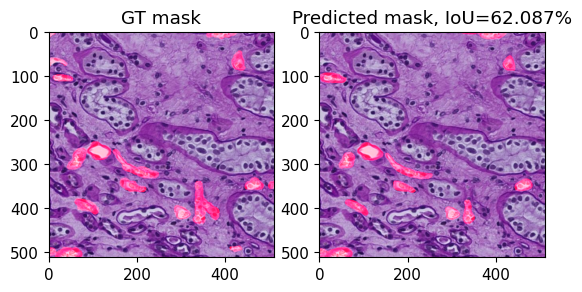

In [38]:
%matplotlib inline

metric_iou = torchmetrics.JaccardIndex(task='binary', num_classes=1)
iou = []
with torch.no_grad():
    for img, msk in test_loader:
        if not torch.is_tensor(msk):
            msk = torch.tensor(msk).unsqueeze(0)
        if len(img.shape) < 4:
            img = img.unsqueeze(0)
        pred_msk = 0   
        
        # Убираем все классы кроме 1 из gt mask
        msk[msk==2] = 0
        msk[msk==3] = 0
        
        img = img.to(device)
    
        model.eval()
        pred_msk = model(img)
    
        img, msk = img[0], msk[0]
        img, msk = img.cpu().detach().numpy().transpose((1,2,0)), msk.numpy()
        img, msk = img_denorm(img), msk.astype(np.uint8)
        if msk.max():
            msk = msk*(255//msk.max())

    
        plt.subplot(1,2,1)
        show_masked(img, msk)
        plt.title('GT mask')
    
    
        pred_msk = pred_msk.cpu().detach().numpy()[0]
        
        plt.subplot(1,2,2)
        
        pred_msk_threshold = (pred_msk[1] > 0.5).astype(np.uint8)
        
        show_masked(img, pred_msk_threshold*255)
        msk = (msk/255).astype(np.uint8)
        
        IoU = metric_iou(torch.tensor(pred_msk_threshold), torch.tensor(msk))
        iou.append(IoU)
        plt.title(f'Predicted mask, IoU={IoU*100:.3f}%')
    
        break
#     print(np.mean(np.array(iou)))

In [71]:
pred_msk_threshold

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [112]:
np.unique(msk)

array([0, 1], dtype=uint8)

In [305]:
# 0.15845025

In [33]:
# Mean IoU

IoU = []
IoU_SAM = []
metric_iou = torchmetrics.JaccardIndex(task='binary', num_classes=1)
test_loader_iou = DataLoader(test_data,
                        batch_size=1,
                       shuffle=False)

for img, mask,_ in test_loader:
    
    GT_mask = mask.cpu().numpy().squeeze()
    
    pred_mask = model(img.to(device))
    with torch.no_grad():
        pred_mask = pred_mask.cpu().numpy().squeeze()
        mask = mask.numpy().squeeze()
    
#     print(img.shape)
    _, pred_SAM = SAM_results(img[0],mask.astype(np.uint8))
    
    pred = torch.from_numpy(pred_mask)
    mask = torch.from_numpy(np.round(mask))
    pred_SAM = torch.from_numpy(pred_SAM/255)
    
    iou = metric_iou(pred, mask)
    iou_SAM = metric_iou(pred_SAM, mask)
    
    IoU.append(iou)
    IoU_SAM.append(iou_SAM)
    
IoU_SAM_mean = np.nanmean(IoU_SAM)    
IoU_mean = np.nanmean(IoU)

print(f'Mean IoU = {IoU_mean*100:.2f}%')
print(f'Mean SAM IoU = {IoU_SAM_mean*100:.2f}%')

NameError: name 'SAM_results' is not defined

100%|████████████████████████████████████████████████████████████████████████████████| 327/327 [00:46<00:00,  7.10it/s]


62.73828148841858 %


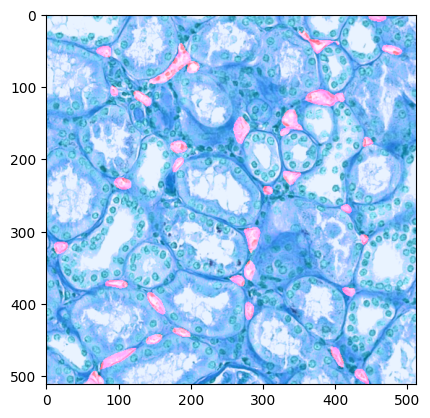

In [27]:
IoU_list = []
metric_iou = torchmetrics.JaccardIndex(task='binary', num_classes=1)


for img, msk in tqdm(test_loader):
        if not torch.is_tensor(msk):
            msk = torch.tensor(msk).unsqueeze(0)
        if len(img.shape) < 4:
            img = img.unsqueeze(0)
        pred_msk = 0   
        
        # Убираем все классы кроме 1 из gt mask
#         msk[msk==1] = 0
        msk[msk==3] = 0
        msk[msk==2] = 0
        
        img = img.to(device)
    
        model.eval()
        pred_msk = model(img)

    
        img, msk = img[0], msk[0]
        img, msk = img.cpu().detach().numpy().transpose((1,2,0)), msk.numpy()
        img, msk = img_denorm(img), msk.astype(np.uint8)
        if msk.max():
            msk = msk*(255//msk.max())  
    
        pred_msk = pred_msk.cpu().detach().numpy()[0]
        
        
        pred_msk_threshold = (pred_msk[1] > 0.5).astype(np.uint8)
        
        show_masked(img, pred_msk_threshold*255)
        msk = (msk/255).astype(np.uint8)
        
        IoU = metric_iou(torch.tensor(pred_msk_threshold), torch.tensor(msk))
        
        IoU_list.append(IoU)

all_IoU = np.array(IoU_list)
print(np.nanmean(all_IoU)*100,'%')

In [16]:
# Чето все время 56.70% SAM IoU ??

In [ ]:
# Mean IoU = 34.18%
# Mean SAM IoU = 56.70%

In [20]:
torch.cuda.empty_cache()

NameError: name 'SAM_results' is not defined

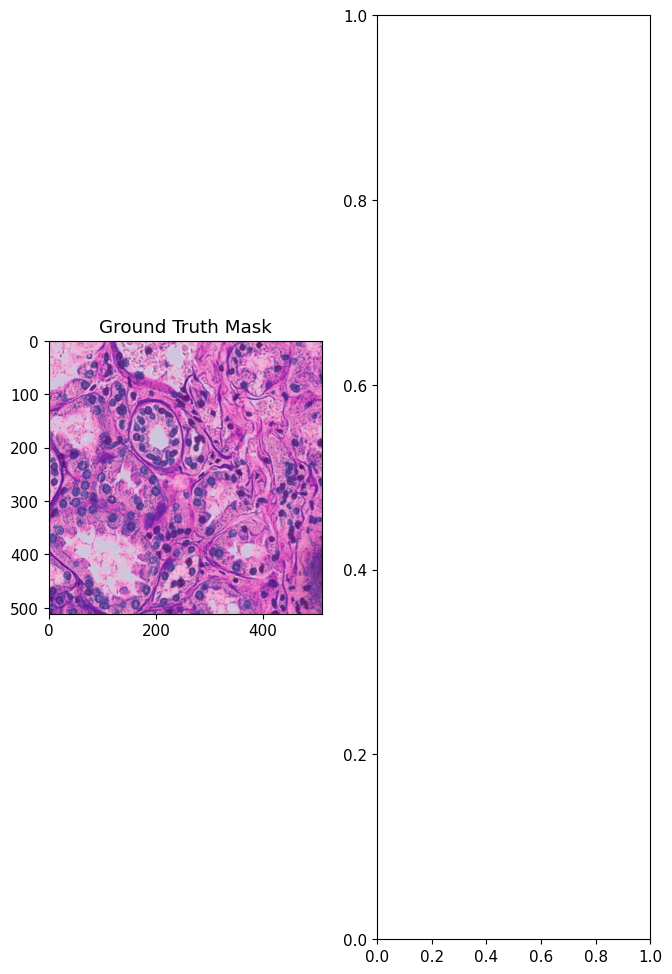

In [20]:
# Some predictions visualised
model.eval()
metric_iou = torchmetrics.JaccardIndex(task='binary', num_classes=1)

plt.figure(figsize=(12,12))

for img, mask, _ in test_loader:

    plt.subplot(1, 3, 1)
    
    # Если увеличить batch больше 1, нужно добавить [0]
    GT_mask = mask.cpu().numpy().squeeze()[0]
    
    _,applied_mask = apply_masks(img,GT_mask)
    plt.imshow(applied_mask)
    plt.title('Ground Truth Mask')
    
    img = img.to(device)
    pred_mask = model(img)

    with torch.no_grad():
        pred_mask = pred_mask.cpu().numpy().squeeze()
    
    plt.subplot(1,3,2)
    
    connected_pred, _ = Connected_components(pred_mask[0])
    
    SAM_pred,_, SAM_iou = SAM_results(img[0],pred_mask[0])

    plt.imshow(SAM_pred)
    plt.title(f"IoU = {SAM_iou*100:.2f}% for SAM mask")
    
    plt.subplot(1,3,3)
    _,applied_mask_pred = apply_masks(img,np.round(pred_mask[0]))
    plt.imshow(applied_mask_pred)
#     plt.imshow(np.round(pred_mask), cmap='gray')

    plt.tight_layout()
    
    # IoU
    
    with torch.no_grad():
        mask = mask.numpy().squeeze()
    
    pred = torch.from_numpy(pred_mask)
    mask = torch.from_numpy(mask)
    
    iou = metric_iou(np.round(pred), np.round(mask))
    plt.title(f'IoU = {iou*100:.2f}% for UNet')
    
    break
